In [1]:
import string
import nltk
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [24]:
%pip install rouge-score
%pip install matplotlib

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/asharfarooq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/asharfarooq/nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/asharfarooq/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [25]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt

In [4]:
lemmatizer = WordNetLemmatizer()

In [5]:
def preprocess(text):
	# Steps:
	# 1. lowercase
	# 2. Lammetize. (It does not stem. Try to preserve structure not to overwrap with potential acronym).
	# 3. Remove stop words.
	# 4. Remove punctuations.
	# 5. Remove character with the length size of 1.

	lowered = str.lower(text)

	stop_words = set(stopwords.words('english'))
	word_tokens = word_tokenize(lowered)

	words = []
	for w in word_tokens:
		if w not in stop_words:
			if w not in string.punctuation:
				if len(w) > 1:
					lemmatized = lemmatizer.lemmatize(w)
					words.append(lemmatized)

	return words

In [6]:
def calculate_jaccard(word_tokens1, word_tokens2):
	# Combine both tokens to find union.
	both_tokens = word_tokens1 + word_tokens2
	union = set(both_tokens)

	# Calculate intersection.
	intersection = set()
	for w in word_tokens1:
		if w in word_tokens2:
			intersection.add(w)

	jaccard_score = len(intersection)/len(union)
	return jaccard_score

In [8]:
reviews_1000_movies = pd.read_csv("reviews_1000_movies.csv")
reviews_1000_movies['processed_reviews'] = reviews_1000_movies['review_content'].apply(preprocess)

In [9]:
# For each review, calculate similarity with all other reviews, i < j
# Room for optimization (half the time) by not recalculating for already calculated pairs

In [10]:
def get_most_representative_review(reviews):
    '''
    reviews is a pandas dataframe
    '''
    similarity_dict = {review: [] for review in reviews.index}
    for i in range(len(reviews)):
        review1 = reviews.iloc[i]['processed_reviews']
        for j in range(len(reviews)):
            review2 = reviews.iloc[j]['processed_reviews']
            similarity_dict[reviews.index[i]].append(calculate_jaccard(review1, review2))
    
    average_similarity_dict = {k:np.sum(v)/len(v) for k,v in similarity_dict.items()}
    max_index = max(average_similarity_dict, key=average_similarity_dict.get)
    most_representative_review = reviews.loc[max_index]
    return most_representative_review


In [11]:
reviews0814255 = reviews_1000_movies[reviews_1000_movies['rotten_tomatoes_link'] == 'm/0814255']

In [12]:
get_most_representative_review(reviews0814255)

rotten_tomatoes_link                                            m/0814255
critic_name                                              Bill Goodykoontz
top_critic                                                           True
publisher_name                                           Arizona Republic
review_type                                                         Fresh
review_score                                                        3.5/5
review_date                                                    2010-02-10
review_content          Percy Jackson isn't a great movie, but it's a ...
processed_reviews       [percy, jackson, n't, great, movie, 's, good, ...
Name: 7, dtype: object

In [13]:
representative_reviews = []
for unique_id in reviews_1000_movies['rotten_tomatoes_link'].unique():
    reviews = reviews_1000_movies[reviews_1000_movies['rotten_tomatoes_link'] == unique_id]
    reviews['review_length'] = reviews.processed_reviews.apply(len)
    representative_reviews.append(get_most_representative_review(reviews[reviews['review_length'] != 0]))

In [15]:
pd.concat(representative_reviews, axis=1).T

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content,processed_reviews,review_length
7,m/0814255,Bill Goodykoontz,True,Arizona Republic,Fresh,3.5/5,2010-02-10,"Percy Jackson isn't a great movie, but it's a ...","[percy, jackson, n't, great, movie, 's, good, ...",17
247,m/0878835,Moira MacDonald,True,Seattle Times,Fresh,4/4,2010-06-18,Nicole Holofcener's lovely Please Give is a sm...,"[nicole, holofcener, 's, lovely, please, give,...",14
296,m/10,Roger Ebert,True,Chicago Sun-Times,Fresh,4/4,2004-10-23,Blake Edwards's 10 is perhaps the first comedy...,"[blake, edward, 's, 10, perhaps, first, comedy...",16
330,m/1000013-12_angry_men,Matthew Pejkovic,False,Matt's Movie Reviews,Fresh,4/5,2010-07-06,A brilliant courtroom drama whose strength lie...,"[brilliant, courtroom, drama, whose, strength,...",17
359,m/1000079-20000_leagues_under_the_sea,David Cornelius,False,eFilmCritic.com,Fresh,5/5,2006-07-03,"This is one of Disney's best, and one of the a...","[one, disney, 's, best, one, all-time, adventu...",10
...,...,...,...,...,...,...,...,...,...,...
67395,m/211,Noel Murray,True,Los Angeles Times,Rotten,NaN,2018-06-07,Even the subset of Nicolas Cage fans who like ...,"[even, subset, nicolas, cage, fan, like, actor...",17
67513,m/21_and_over,Jennifer Heaton,False,Alternative Lens,Rotten,5.5/10,2018-11-01,It's like The Hangover...but in college. And t...,"['s, like, hangover, ..., college, 's]",6
67634,m/21_grams,Jeffrey Bruner,False,Des Moines Register,Fresh,4/5,2003-12-26,"A mind-bending, scrambled egg of a drama, 21 G...","[mind-bending, scrambled, egg, drama, 21, gram...",12
67880,m/21_jump_street_2011,R.L. Shaffer,False,IGN DVD,Fresh,8/10,2012-06-27,"Slick and funny as hell, 21 Jump Street is one...","[slick, funny, hell, 21, jump, street, one, be...",10


In [17]:
hypothesis = list(pd.concat(representative_reviews, axis=1).T['review_content'])

In [20]:
h = pd.concat(representative_reviews, axis=1).T
gt = pd.read_csv('rotten_tomatoes_movies.csv')
gt2 = gt[gt['rotten_tomatoes_link'].isin(h['rotten_tomatoes_link'])]
ground_truth = list(gt2.critics_consensus)

In [26]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)

#running the ROUGE evaluation for certain subset of ground truth and hypothesis pairs
num_of_iterations = 1000
all_rouges_1_scores = []
all_rouges_2_scores = []
for i in range(num_of_iterations):
    all_scores_obj = scorer.score(hypothesis[i], ground_truth[i])
    all_rouges_1_scores.append(all_scores_obj["rouge1"])
    all_rouges_2_scores.append(all_scores_obj["rouge2"])

In [27]:
# building up metric results for Rouge 1

rouge_1_precisions = []
rouge_1_recall = []
rouge_1_f1 = []
for each_rouge_1_score in all_rouges_1_scores:
    rouge_1_precisions.append(each_rouge_1_score.precision)
    rouge_1_recall.append(each_rouge_1_score.recall)
    rouge_1_f1.append(each_rouge_1_score.fmeasure)

In [28]:
# analyzing rouge 1 results

avg_rouge_1_precision_score = np.average(rouge_1_precisions)
avg_rouge_1_recall_score = np.average(rouge_1_recall)
avg_rouge_1_f1_score = np.average(rouge_1_f1)

print(f'The average precision value for the rouge 1 scores is {avg_rouge_1_precision_score}')
print(f'The average recall value for the rouge 1 scores is {avg_rouge_1_recall_score}')
print(f'The average f1 value for the rouge 1 scores is {avg_rouge_1_f1_score}')

The average precision value for the rouge 1 scores is 0.20072133494712605
The average recall value for the rouge 1 scores is 0.23756888593675768
The average f1 value for the rouge 1 scores is 0.2042613448544598


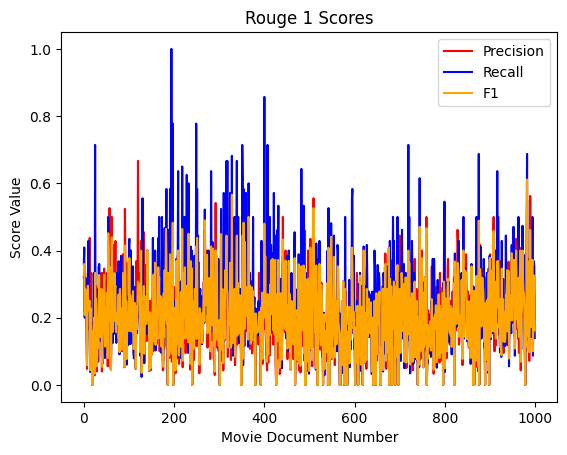

In [29]:
# graping rouge 1 metrics

x_axis = range(num_of_iterations)

plt.title("Rouge 1 Scores")
plt.xlabel("Movie Document Number")
plt.ylabel("Score Value")
plt.plot(x_axis, rouge_1_precisions, color ="red", label="Precision")
plt.plot(x_axis, rouge_1_recall, color ="blue", label= "Recall")
plt.plot(x_axis, rouge_1_f1, color ="orange", label="F1")

plt.legend()
plt.show()

In [30]:
# building up metric results for Rouge 2

rouge_2_precisions = []
rouge_2_recall = []
rouge_2_f1 = []
for each_rouge_2_score in all_rouges_2_scores:
    rouge_2_precisions.append(each_rouge_2_score.precision)
    rouge_2_recall.append(each_rouge_2_score.recall)
    rouge_2_f1.append(each_rouge_2_score.fmeasure)

In [31]:
# analyzing rouge 2 results

avg_rouge_2_precision_score = np.average(rouge_2_precisions)
avg_rouge_2_recall_score = np.average(rouge_2_recall)
avg_rouge_2_f1_score = np.average(rouge_2_f1)

print(f'The average precision value for the rouge 2 scores is {avg_rouge_2_precision_score}')
print(f'The average recall value for the rouge 2 scores is {avg_rouge_2_recall_score}')
print(f'The average f1 value for the rouge 2 scores is {avg_rouge_2_f1_score}')

The average precision value for the rouge 2 scores is 0.05450731795952248
The average recall value for the rouge 2 scores is 0.07028000503180014
The average f1 value for the rouge 2 scores is 0.05743234712391907


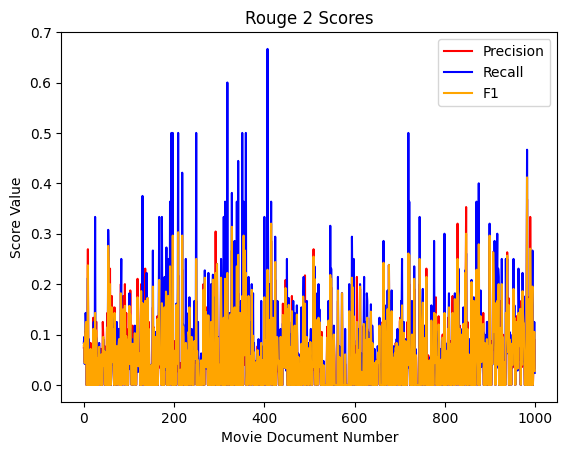

In [32]:
# graping rouge 2 metrics

x_axis = range(num_of_iterations)

plt.title("Rouge 2 Scores")
plt.xlabel("Movie Document Number")
plt.ylabel("Score Value")
plt.plot(x_axis, rouge_2_precisions, color ="red", label="Precision")
plt.plot(x_axis, rouge_2_recall, color ="blue", label= "Recall")
plt.plot(x_axis, rouge_2_f1, color ="orange", label="F1")

plt.legend()
plt.show()